In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.impute import KNNImputer

In [32]:
# donnees ademe
data_ademe = pd.read_csv("donnees_ademe_finales_69.csv")
data_ademe.shape

(434380, 34)

In [33]:
data_ademe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434380 entries, 0 to 434379
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   date_reception_dpe                 434380 non-null  object 
 1   conso_auxiliaires_ef               434379 non-null  float64
 2   cout_eclairage                     434373 non-null  float64
 3   cout_chauffage                     434371 non-null  float64
 4   conso_5_usages_par_m2_ef           434372 non-null  float64
 5   emission_ges_chauffage             434374 non-null  float64
 6   modele_dpe                         434380 non-null  object 
 7   type_energie_n1                    434380 non-null  object 
 8   emission_ges_eclairage             434380 non-null  float64
 9   code_postal_ban                    434380 non-null  int64  
 10  emission_ges_ecs                   434380 non-null  float64
 11  conso_5_usages_ef                  4343

In [26]:
pd.set_option('display.max_columns', None)
data_ademe.columns

Index(['date_reception_dpe', 'conso_auxiliaires_ef', 'cout_eclairage',
       'cout_chauffage', 'conso_5_usages_par_m2_ef', 'emission_ges_chauffage',
       'modele_dpe', 'type_energie_n1', 'emission_ges_eclairage',
       'code_postal_ban', 'emission_ges_ecs', 'conso_5_usages_ef',
       'surface_habitable_logement', 'cout_ecs',
       'emission_ges_5_usages_par_m2', 'cout_auxiliaires',
       'emission_ges_refroidissement', 'conso_chauffage_ef', 'type_batiment',
       'conso_ecs_ef', 'emission_ges_5_usages', 'etiquette_ges',
       'etiquette_dpe', 'cout_total_5_usages', 'conso_refroidissement_ef',
       'conso_eclairage_ef', 'cout_refroidissement',
       'type_energie_principale_chauffage', 'numero_dpe', 'numero_dpe.1',
       'adresse_ban', 'adresse_norm', 'latitude', 'longitude'],
      dtype='object')

## Nettoyage des données

In [34]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

def clean_data(df, n_neighbors=5, cap_outliers=True, quantile=0.95, verbose=True):
    """
    Nettoyage complet du dataset ADEME :
    - Suppression des doublons
    - Imputation des valeurs manquantes (KNN + mode)
    - Capping (tronquage) des valeurs extrêmes au quantile choisi

    Paramètres :
        df : DataFrame à nettoyer
        n_neighbors : nombre de voisins pour KNN Imputer
        cap_outliers : True pour tronquer les valeurs extrêmes
        quantile : quantile supérieur pour le capping (par défaut 0.95)
        verbose : True pour afficher les étapes
    """

    if verbose: print(f"\n Taille initiale du dataset : {df.shape}\n")

    
    #  SUPPRESSION DES DOUBLONS
    
    if verbose: print(" Vérification des doublons...")
    doublons = df.duplicated()
    if doublons.any():
        if verbose: print(f" {doublons.sum()} doublons trouvés — suppression...")
        df = df.drop_duplicates()
        if verbose: print(f" Nouvelle taille du dataset : {df.shape}\n")
    else:
        if verbose: print(" Aucun doublon trouvé.\n")

    
    #  TRAITEMENT DES VALEURS MANQUANTES
    
    if verbose: print(" Imputation des valeurs manquantes...\n")

    df_num = df.select_dtypes(include=np.number)
    df_cat = df.select_dtypes(exclude=np.number)

    # --- Numériques : KNN Imputer ---
    if df_num.isna().sum().any():
        if verbose:
            print(" Colonnes numériques avec NaN (traitement KNN) :")
            print(df_num.isna().sum()[df_num.isna().sum() > 0])
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num),
                                      columns=df_num.columns,
                                      index=df.index)
        df[df_num.columns] = df_num_imputed
        if verbose: print(f"  Valeurs numériques imputées (k={n_neighbors})\n")
    else:
        if verbose: print(" Aucun NaN dans les colonnes numériques.\n")

    # --- Catégorielles : Mode ---
    if df_cat.isna().sum().any():
        if verbose:
            print(" Colonnes catégorielles avec NaN :")
            print(df_cat.isna().sum()[df_cat.isna().sum() > 0])
        for col in df_cat.columns:
            mode_value = df_cat[col].mode()[0] if not df_cat[col].mode().empty else "Inconnu"
            df[col].fillna(mode_value, inplace=True)
            if verbose: print(f" → {col} : NaN remplacés par '{mode_value}'")
    else:
        if verbose: print(" Aucun NaN dans les colonnes catégorielles.\n")


    #  TRAITEMENT DES OUTLIERS (CAPPING)
    
    if cap_outliers:
        if verbose: print(" Capping (tronquage) des valeurs extrêmes...\n")

        df_num = df.select_dtypes(include=np.number)

        # Colonnes à exclure du capping
        exclude_cols = [
            'code_postal_ban', 'latitude', 'longitude'
        ]

        cols_to_cap = [col for col in df_num.columns if col not in exclude_cols]

        for col in cols_to_cap:
            q_hi = df[col].quantile(quantile)
            q_lo = df[col].quantile(1 - quantile) if df[col].min() < 0 else None

            # Tronquage haut
            upper_mask = df[col] > q_hi
            upper_count = upper_mask.sum()

            # Tronquage bas (si applicable)
            lower_count = 0
            if q_lo is not None:
                lower_mask = df[col] < q_lo
                lower_count = lower_mask.sum()
                df.loc[lower_mask, col] = q_lo

            df.loc[upper_mask, col] = q_hi

            if verbose and (upper_count > 0 or lower_count > 0):
                print(f" → '{col}' : {upper_count} valeurs > P{int(quantile*100)} tronquées à {q_hi:.2f}")

        if verbose: print("\n  Capping terminé.\n")
    else:
        if verbose: print(" Capping désactivé.\n")

    
    # FIN DU NETTOYAGE
    
    if verbose:
        print(f" Taille finale du dataset : {df.shape}")
        print(" Nettoyage complet terminé.\n")

    return df


In [ ]:
# données ademe nettoyées
ademe_clean = clean_data(data_ademe, n_neighbors=5, cap_outliers=True, quantile=0.95)



 Taille initiale du dataset : (434380, 34)

 Vérification des doublons...
 Aucun doublon trouvé.

 Imputation des valeurs manquantes...

 Colonnes numériques avec NaN (traitement KNN) :
conso_auxiliaires_ef               1
cout_eclairage                     7
cout_chauffage                     9
conso_5_usages_par_m2_ef           8
emission_ges_chauffage             6
conso_5_usages_ef                  8
surface_habitable_logement      8594
cout_ecs                           9
emission_ges_5_usages_par_m2       8
cout_auxiliaires                   8
conso_chauffage_ef                 6
emission_ges_5_usages              8
cout_total_5_usages               11
cout_refroidissement               8
latitude                          87
longitude                         87
dtype: int64
  Valeurs numériques imputées (k=5)

 Colonnes catégorielles avec NaN :
adresse_norm    87
dtype: int64
 → date_reception_dpe : NaN remplacés par '2023-12-09'


C:\Users\Surface\AppData\Local\Temp\ipykernel_14860\1124308690.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


 → modele_dpe : NaN remplacés par 'DPE 3CL 2021 méthode logement'
 → type_energie_n1 : NaN remplacés par 'Gaz naturel'
 → type_batiment : NaN remplacés par 'appartement'
 → etiquette_ges : NaN remplacés par 'C'
 → etiquette_dpe : NaN remplacés par 'C'
 → type_energie_principale_chauffage : NaN remplacés par 'Gaz naturel'
 → numero_dpe : NaN remplacés par '2100E0364115L'
 → numero_dpe.1 : NaN remplacés par '2100E0364115L'
 → adresse_ban : NaN remplacés par '173 Avenue Barthélémy Buyer 69005 Lyon'
 → adresse_norm : NaN remplacés par '173 Avenue Barthélémy Buyer 69005 Lyon'
 Capping (tronquage) des valeurs extrêmes...

 → 'conso_auxiliaires_ef' : 21712 valeurs > P95 tronquées à 860.40
 → 'cout_eclairage' : 21716 valeurs > P95 tronquées à 127.70
 → 'cout_chauffage' : 21718 valeurs > P95 tronquées à 2396.00
 → 'conso_5_usages_par_m2_ef' : 21707 valeurs > P95 tronquées à 294.00
 → 'emission_ges_chauffage' : 21719 valeurs > P95 tronquées à 5068.81
 → 'emission_ges_eclairage' : 21668 valeurs >

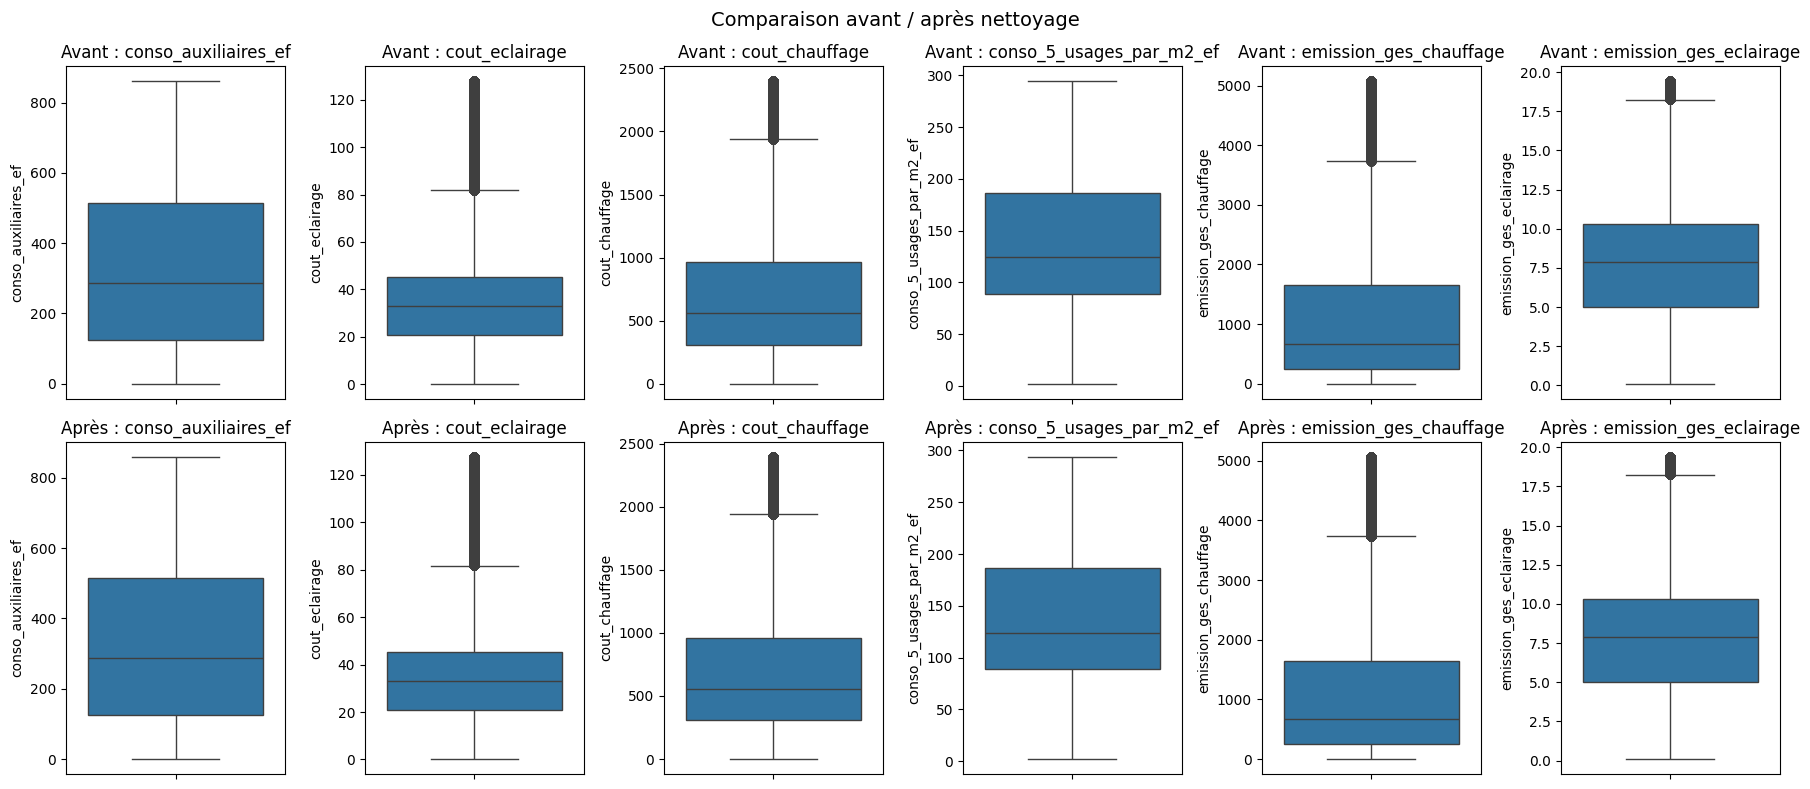

In [38]:

num_cols = data_ademe.select_dtypes(include=np.number).columns[:6]  # exemple sur 6 colonnes

fig, axs = plt.subplots(2, len(num_cols), figsize=(18, 8))
fig.suptitle("Comparaison avant / après nettoyage", fontsize=14)

for i, col in enumerate(num_cols):
    sns.boxplot(y=data_ademe[col], ax=axs[0, i])
    axs[0, i].set_title(f"Avant : {col}")
    sns.boxplot(y=ademe_clean[col], ax=axs[1, i])
    axs[1, i].set_title(f"Après : {col}")

plt.tight_layout()
plt.show()

In [39]:
ademe_clean.to_csv("donnees_ademe_finales_nettoyees_69.csv", index=False, encoding='utf-8')

In [46]:
import pandas as pd
import numpy as np  

In [70]:

ademe_clean = pd.read_csv("donnees_ademe_finales_nettoyees_69.csv")

In [71]:
def energie(type_energie) : 
    if type_energie == "Gaz naturel":
        return "Gaz_naturel"
    elif type_energie == "Électricité":
        return "Electricite"
    elif type_energie == "Réseau de Chauffage urbain":
        return "Reseau_de_Chauffage_urbain"
    elif type_energie == "Fioul domestique":
        return "Fioul domestique"
    else:
        return "Autres"
ademe_clean['type_energie_recodee'] = ademe_clean['type_energie_n1'].apply(energie).astype('object')
ademe_clean['type_energie_recodee'].value_counts()

type_energie_recodee
Gaz_naturel                   202657
Electricite                   150779
Reseau_de_Chauffage_urbain     67398
Fioul domestique                7437
Autres                          6109
Name: count, dtype: int64

## Analyse univariée des données

In [72]:
donnee_num = ademe_clean.select_dtypes(include=np.number)
donnee_cat = ademe_clean.select_dtypes(exclude=np.number)

In [73]:
donnee_num.describe()

,conso_auxiliaires_ef,cout_eclairage,cout_chauffage,conso_5_usages_par_m2_ef,emission_ges_chauffage,emission_ges_eclairage,code_postal_ban,emission_ges_ecs,conso_5_usages_ef,surface_habitable_logement,...,emission_ges_refroidissement,conso_chauffage_ef,conso_ecs_ef,emission_ges_5_usages,cout_total_5_usages,conso_refroidissement_ef,conso_eclairage_ef,cout_refroidissement,latitude,longitude
count,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,...,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000,434380.000000
mean,328.542172,38.967612,738.539636,141.509086,1210.082873,8.104367,69203.883943,320.593626,9693.928464,66.744386,...,0.057691,7096.679486,2092.648322,1605.101142,1126.681916,1.228794,121.479215,0.281447,45.768241,4.826043
std,255.042700,28.382175,593.783156,68.394447,1354.566192,4.534416,237.337777,256.040962,7020.503337,31.484462,...,0.243174,6374.865415,967.602826,1553.350704,676.513911,5.084030,64.230280,1.164667,0.086188,0.096773
min,0.000000,0.200000,0.000000,2.000000,0.000000,0.100000,69001.000000,0.000000,132.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,38.300000,0.000000,1.000000,0.000000,45.457143,2.044963
25%,124.700000,20.900000,310.400000,89.000000,254.700000,5.000000,69007.000000,109.400000,4561.300000,44.900000,...,0.000000,2468.400000,1549.100000,447.800000,644.800000,0.000000,76.800000,0.000000,45.735102,4.798272
50%,286.700000,32.900000,558.000000,124.000000,664.800000,7.900000,69120.000000,280.000000,7500.350000,64.000000,...,0.000000,4885.700000,1881.700000,1051.400000,951.300000,0.000000,116.200000,0.000000,45.758717,4.842541
75%,514.500000,45.300000,962.000000,186.700000,1648.425000,10.300000,69330.000000,461.525000,12711.600000,81.800000,...,0.000000,9671.700000,2306.600000,2215.000000,1407.600000,0.000000,150.600000,0.000000,45.778387,4.875173
max,860.400000,127.700000,2396.000000,294.000000,5068.810000,19.400000,69970.000000,1001.105000,28999.620000,146.300000,...,1.100000,24922.210000,5031.200000,5919.305000,2975.015000,22.700000,286.400000,5.200000,48.800330,5.133277


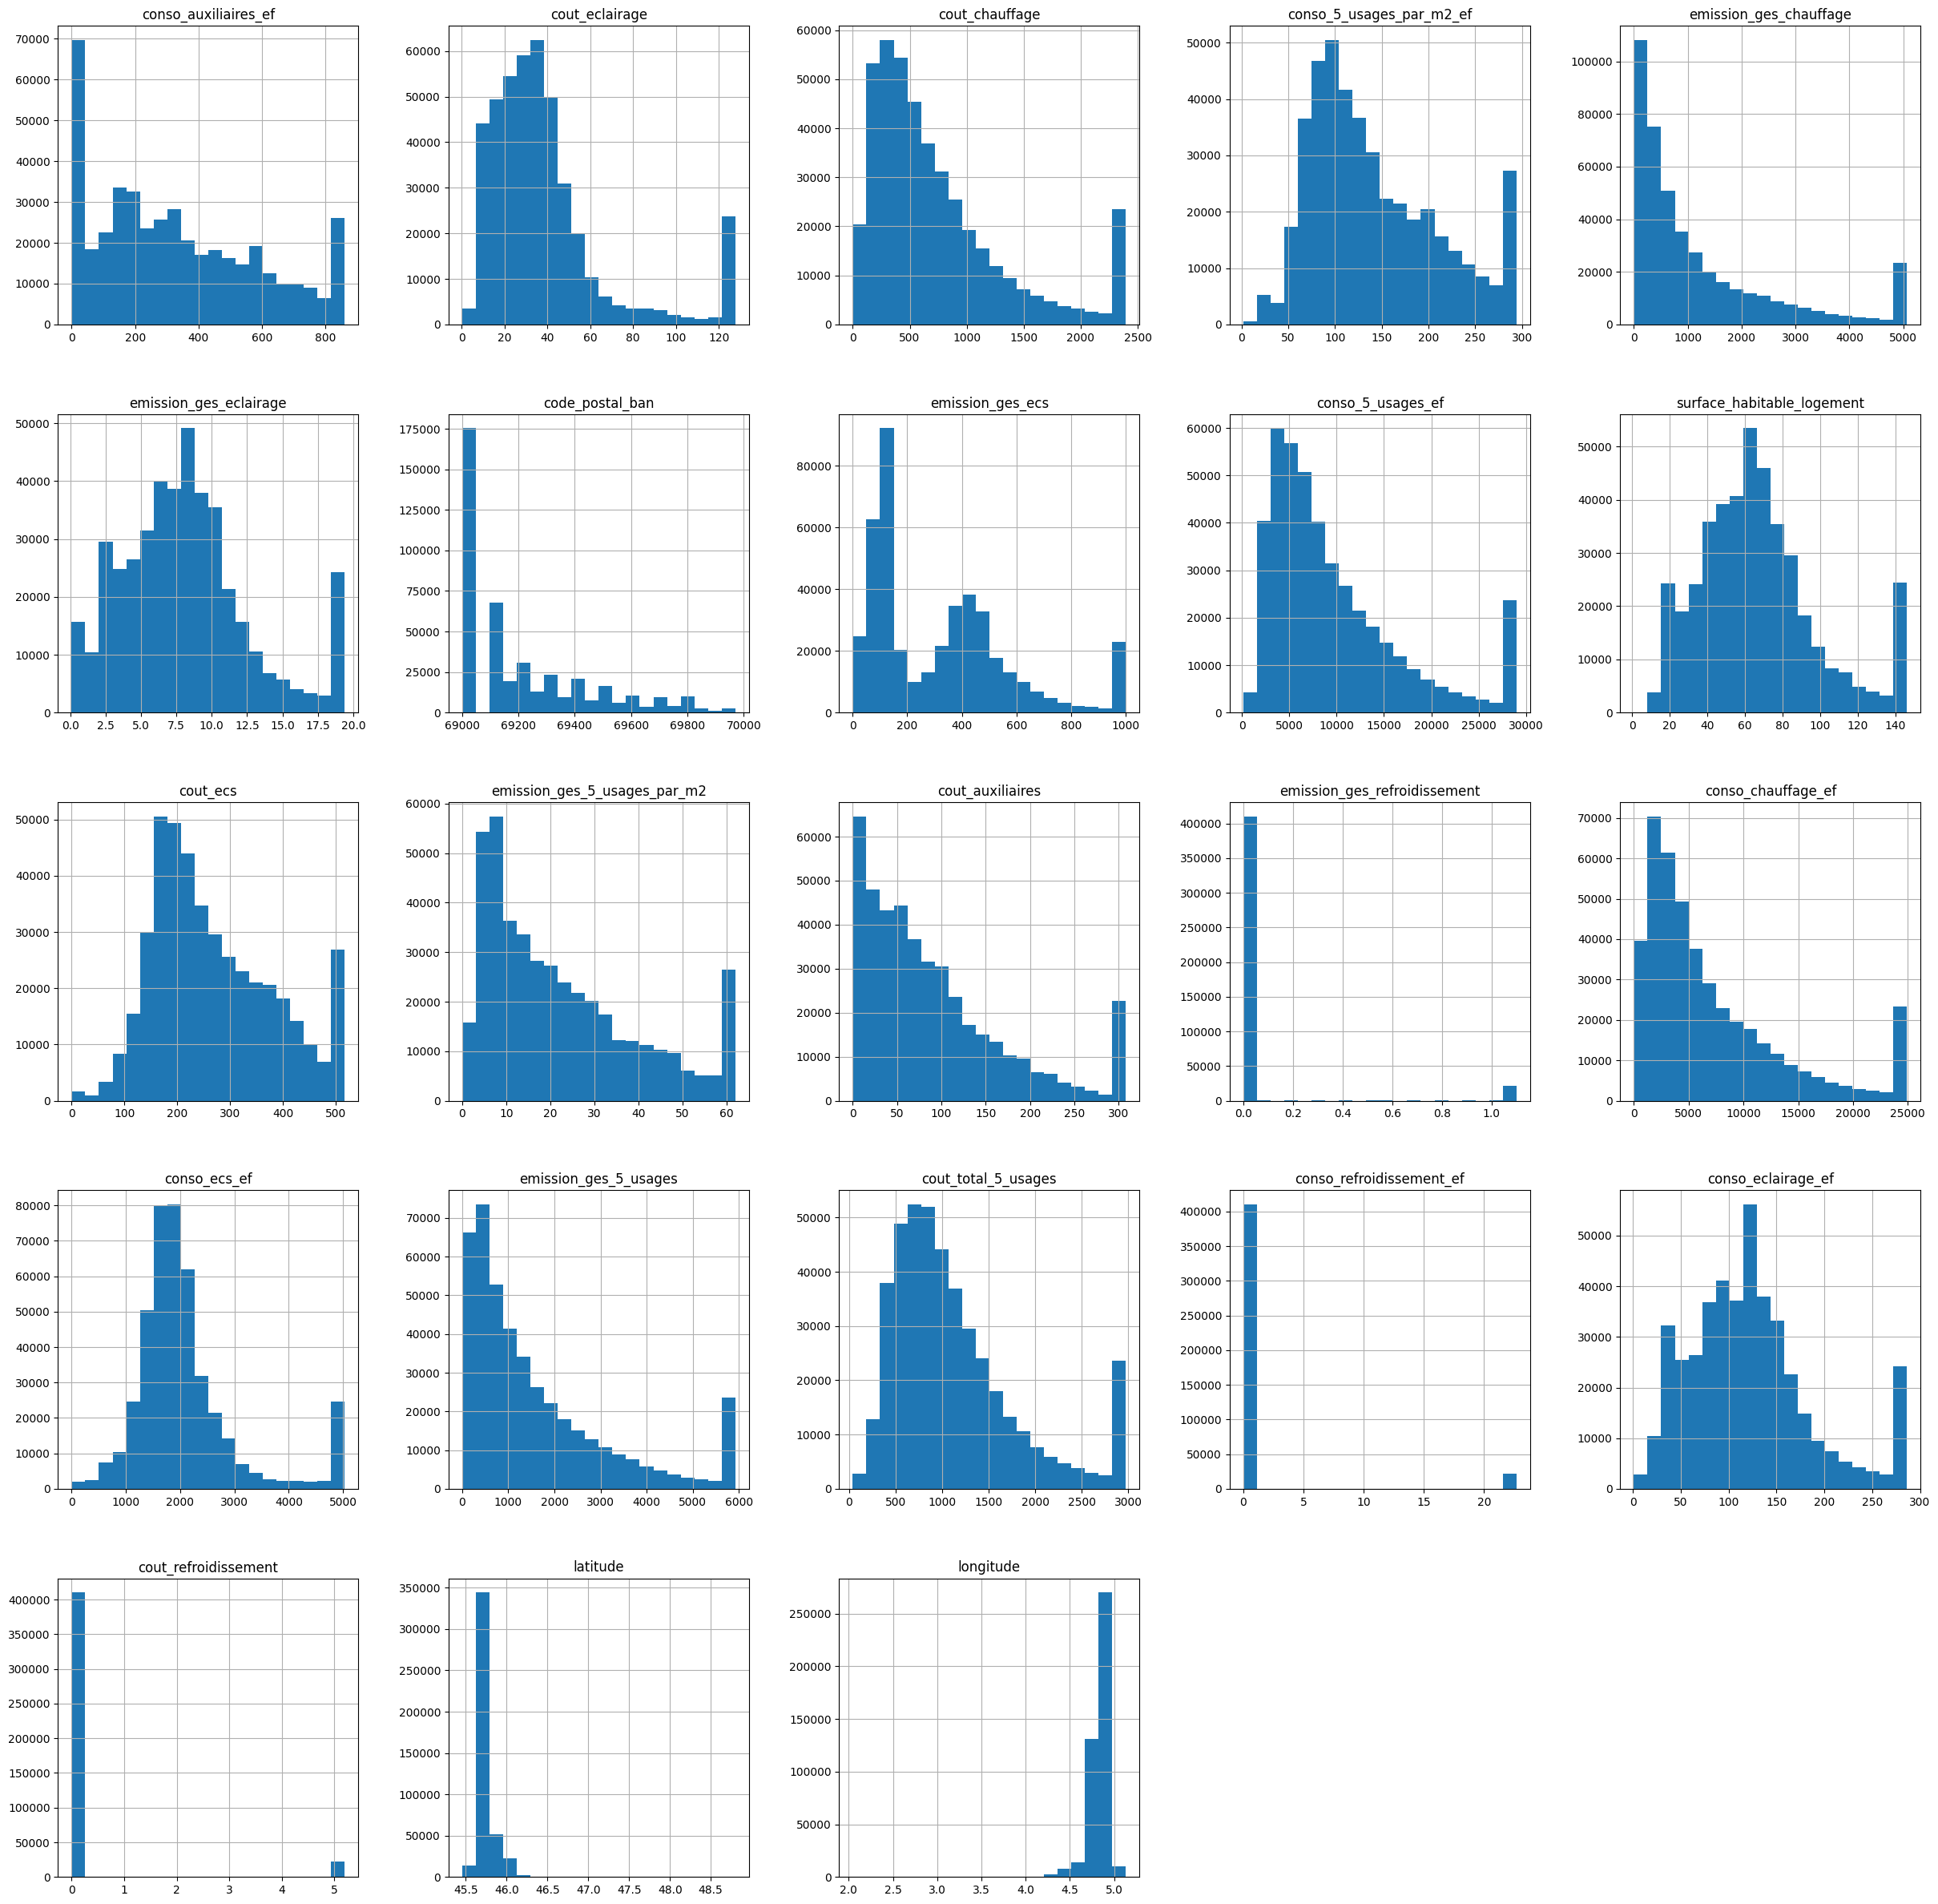

In [8]:
donnee_num.hist(figsize = (30, 30), bins = 20, legend = False)
plt.show()

In [74]:
donnee_cat['etiquette_dpe'].value_counts()

etiquette_dpe
C    163436
D    132788
E     73988
F     24280
B     17937
G     15193
A      6758
Name: count, dtype: int64

<Axes: xlabel='etiquette_dpe', ylabel='count'>

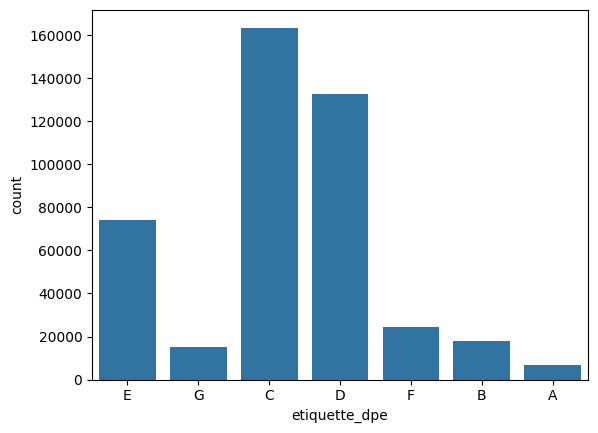

In [10]:
sns.countplot(x=donnee_cat['etiquette_dpe'])

In [51]:
donnee_cat['etiquette_ges'].value_counts()

etiquette_ges
C    167109
B     86106
D     78050
A     60907
E     29081
F      9921
G      3206
Name: count, dtype: int64

In [52]:
donnee_cat['type_batiment'].value_counts()

type_batiment
appartement    376181
maison          49331
immeuble         8868
Name: count, dtype: int64

In [53]:
donnee_cat['type_energie_principale_chauffage'].value_counts()

type_energie_principale_chauffage
Gaz naturel                                                     196559
Électricité                                                     157756
Réseau de Chauffage urbain                                       66033
Fioul domestique                                                  7139
Bois – Bûches                                                     3229
Bois – Granulés (pellets) ou briquettes                           2439
GPL                                                                724
Propane                                                            168
Bois – Plaquettes forestières                                      162
Bois – Plaquettes d’industrie                                      118
Électricité d'origine renouvelable utilisée dans le bâtiment        30
Charbon                                                             21
Butane                                                               2
Name: count, dtype: int64

In [54]:
donnee_cat.describe()

,date_reception_dpe,modele_dpe,type_energie_n1,type_batiment,etiquette_ges,etiquette_dpe,type_energie_principale_chauffage,numero_dpe,numero_dpe.1,adresse_ban,adresse_norm
count,434380,434380,434380,434380,434380,434380,434380,434380,434380,434380,434380
unique,1570,3,13,3,7,7,13,434380,434380,83118,80959
top,2023-12-09,DPE 3CL 2021 méthode logement,Gaz naturel,appartement,C,C,Gaz naturel,2269E1049302M,2269E1049302M,173 Avenue Barthélémy Buyer 69005 Lyon,173 Avenue Barthélémy Buyer 69005 Lyon
freq,2574,395676,202657,376181,167109,163436,196559,1,1,1527,1614


In [55]:
donnee_num.columns

Index(['conso_auxiliaires_ef', 'cout_eclairage', 'cout_chauffage',
       'conso_5_usages_par_m2_ef', 'emission_ges_chauffage',
       'emission_ges_eclairage', 'code_postal_ban', 'emission_ges_ecs',
       'conso_5_usages_ef', 'surface_habitable_logement', 'cout_ecs',
       'emission_ges_5_usages_par_m2', 'cout_auxiliaires',
       'emission_ges_refroidissement', 'conso_chauffage_ef', 'conso_ecs_ef',
       'emission_ges_5_usages', 'cout_total_5_usages',
       'conso_refroidissement_ef', 'conso_eclairage_ef',
       'cout_refroidissement', 'latitude', 'longitude'],
      dtype='object')

In [56]:
donnee_num_cor = donnee_num[['conso_auxiliaires_ef', 'cout_eclairage', 'cout_chauffage',
       'conso_5_usages_par_m2_ef', 'emission_ges_chauffage',
       'emission_ges_eclairage', 'emission_ges_ecs',
       'conso_5_usages_ef', 'surface_habitable_logement', 'cout_ecs',
       'emission_ges_5_usages_par_m2', 'cout_auxiliaires',
       'emission_ges_refroidissement', 'conso_chauffage_ef', 'conso_ecs_ef',
       'emission_ges_5_usages', 'cout_total_5_usages',
       'conso_refroidissement_ef', 'conso_eclairage_ef',
       'cout_refroidissement',]]

<Axes: >

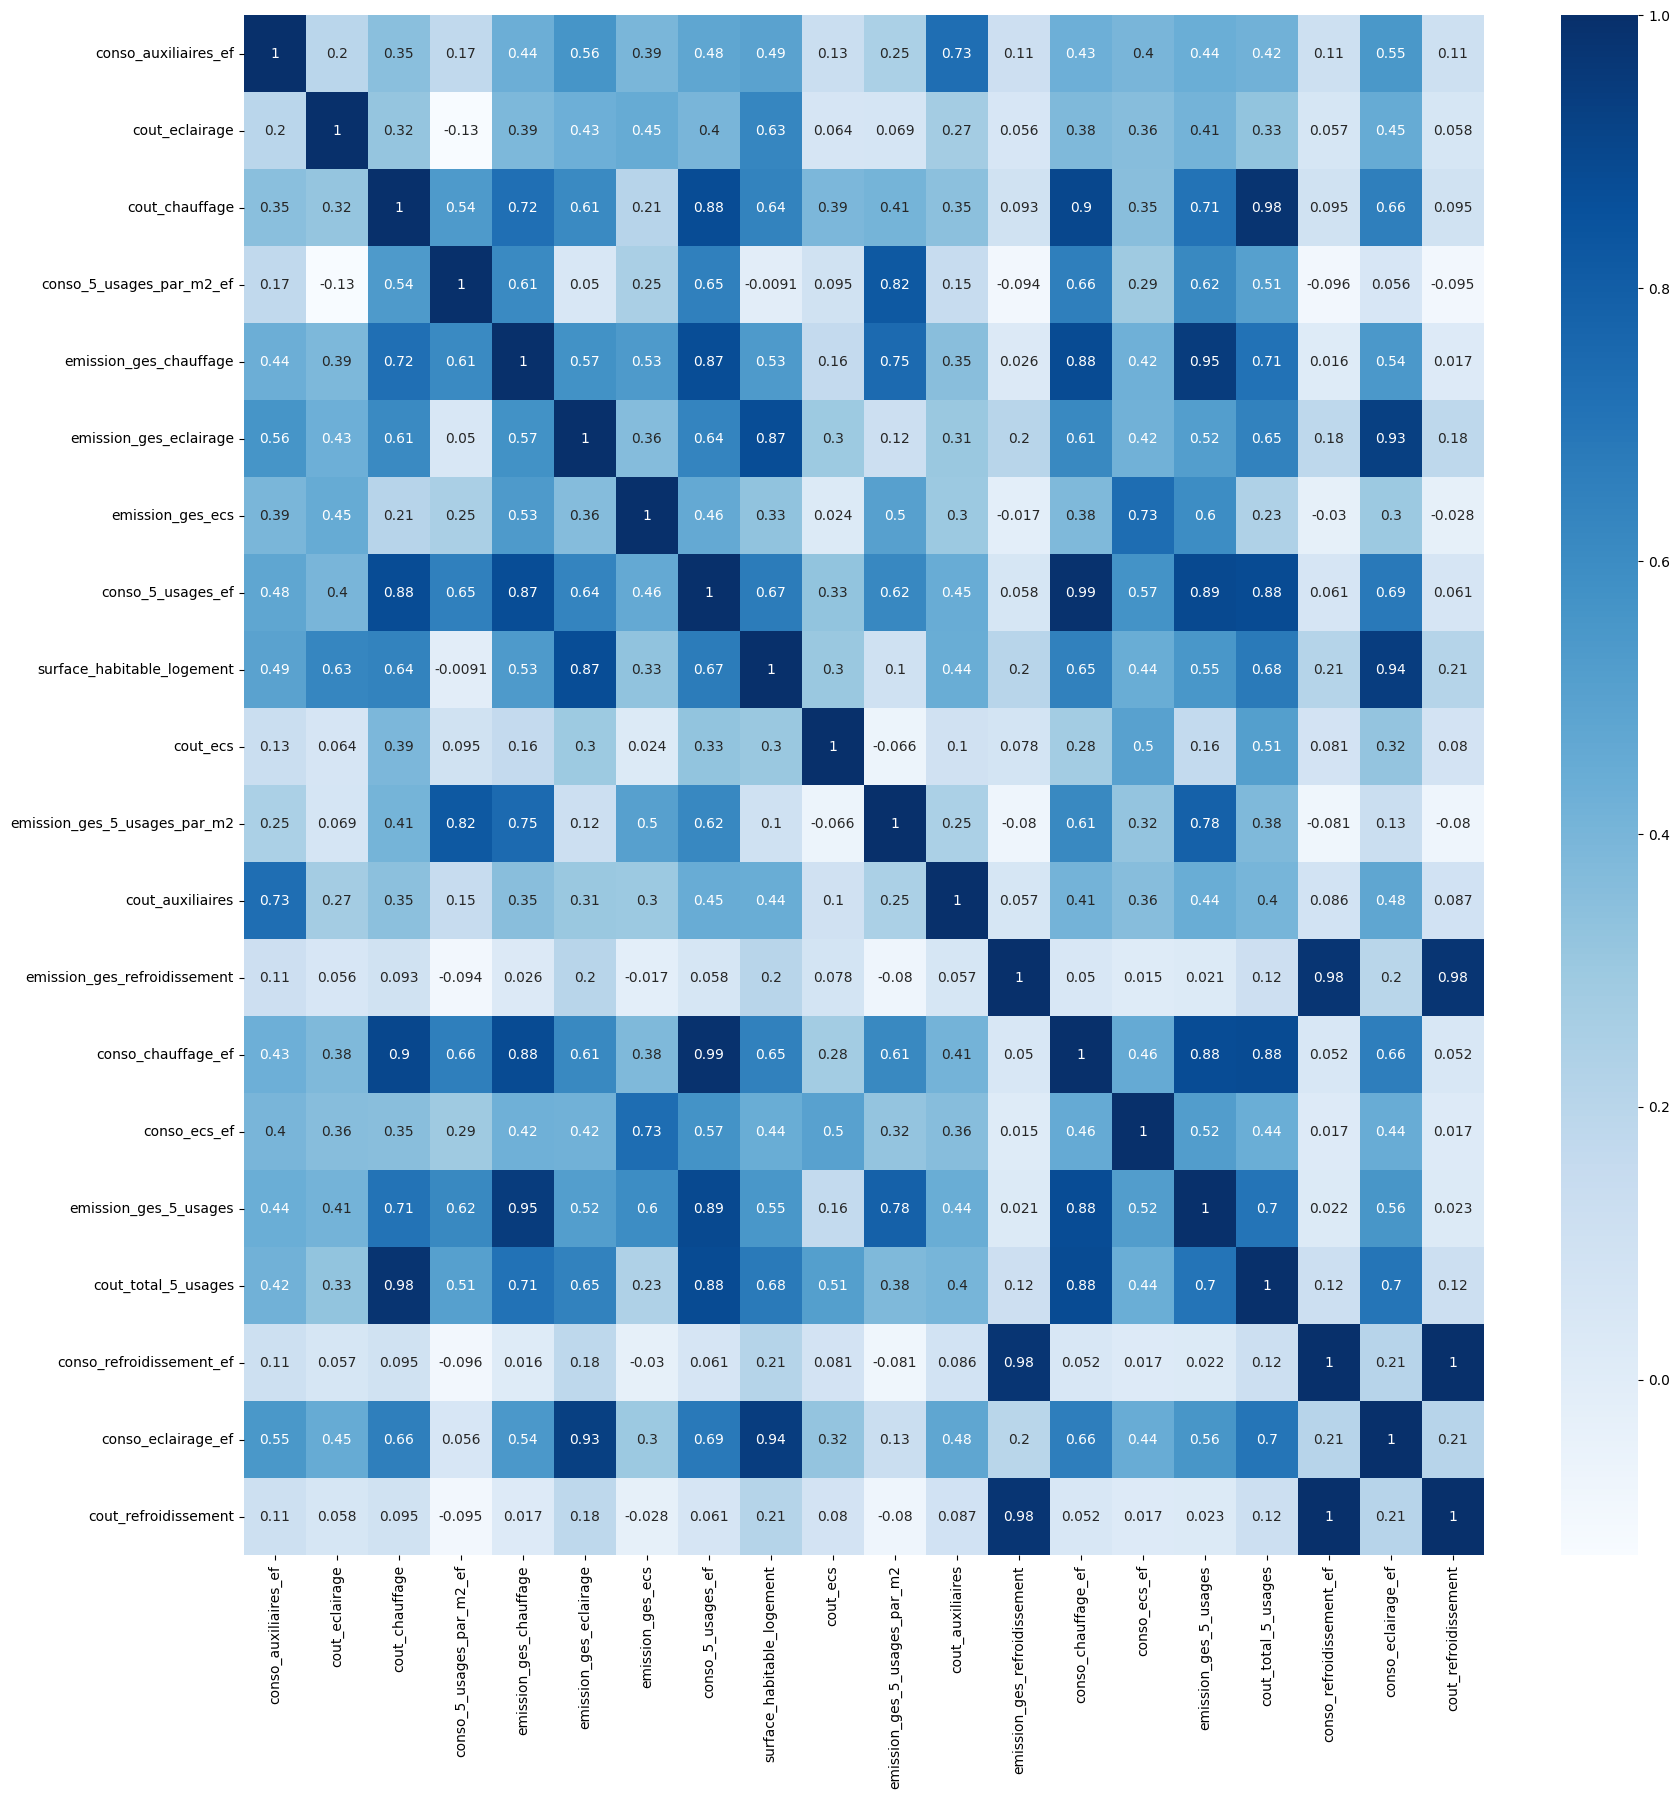

In [57]:
donnee_num_cor = donnee_num_cor.corr()
plt.figure(figsize = [20, 20])
sns.heatmap(donnee_num_cor, annot = True, cmap = "Blues")

In [ ]:
cor_pairs = donnee_num_cor.unstack()
sorted_pairs = cor_pairs.sort_values(kind = 'quicksort')
strong_pairs = sorted_pairs[(abs(sorted_pairs) > 0.7) & (abs(sorted_pairs) < 1)]

print(strong_pairs)

cout_total_5_usages           emission_ges_5_usages           0.703018
emission_ges_5_usages         cout_total_5_usages             0.703018
                              cout_chauffage                  0.706413
cout_chauffage                emission_ges_5_usages           0.706413
cout_total_5_usages           emission_ges_chauffage          0.709699
emission_ges_chauffage        cout_total_5_usages             0.709699
cout_chauffage                emission_ges_chauffage          0.724124
emission_ges_chauffage        cout_chauffage                  0.724124
conso_auxiliaires_ef          cout_auxiliaires                0.730150
cout_auxiliaires              conso_auxiliaires_ef            0.730150
conso_ecs_ef                  emission_ges_ecs                0.732255
emission_ges_ecs              conso_ecs_ef                    0.732255
emission_ges_chauffage        emission_ges_5_usages_par_m2    0.747039
emission_ges_5_usages_par_m2  emission_ges_chauffage          0.747039
emissi

In [14]:
def pairs_redondants(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#  top pairs
def top_pairs_redondants(df, n=10):
    corr_list = df.abs().unstack()
    labels_to_drop = pairs_redondants(df)
    corr_list = corr_list.drop(labels=labels_to_drop).sort_values(ascending=False)
    return corr_list[0:n]

In [28]:
top = top_pairs_redondants(donnee_num_cor, n=len(donnee_num_cor.columns)**2)
top_df = top.reset_index()
top_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

display(top_df[top_df['Correlation'] > 0.8]
)

,Variable 1,Variable 2,Correlation
0,conso_refroidissement_ef,cout_refroidissement,0.998631
1,conso_5_usages_ef,conso_chauffage_ef,0.987186
2,cout_chauffage,cout_total_5_usages,0.979627
3,emission_ges_refroidissement,conso_refroidissement_ef,0.976338
4,emission_ges_refroidissement,cout_refroidissement,0.975485
5,emission_ges_chauffage,emission_ges_5_usages,0.945429
6,surface_habitable_logement,conso_eclairage_ef,0.940962
7,emission_ges_eclairage,conso_eclairage_ef,0.930032
8,cout_chauffage,conso_chauffage_ef,0.900465
9,conso_5_usages_ef,emission_ges_5_usages,0.890685


nous constatons que ces variables sont fortement correlées ce qui signifie qu'elles apportent les mêmes informations. c'est une information importante dans la suite de la modelisation

## variables categorielles

In [59]:
donnee_cat['modele_dpe']

0         DPE 3CL 2021 méthode logement
1         DPE 3CL 2021 méthode logement
2         DPE 3CL 2021 méthode logement
3         DPE 3CL 2021 méthode logement
4         DPE 3CL 2021 méthode logement
                      ...              
434375       DPE NEUF logement : RT2012
434376       DPE NEUF logement : RT2012
434377       DPE NEUF logement : RT2012
434378       DPE NEUF logement : RT2012
434379       DPE NEUF logement : RT2012
Name: modele_dpe, Length: 434380, dtype: object

In [60]:
donnee_cat.columns

Index(['date_reception_dpe', 'modele_dpe', 'type_energie_n1', 'type_batiment',
       'etiquette_ges', 'etiquette_dpe', 'type_energie_principale_chauffage',
       'numero_dpe', 'numero_dpe.1', 'adresse_ban', 'adresse_norm'],
      dtype='object')

In [75]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Fonction pour calculer Cramér's V
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Sélection des variables catégorielles
cat_cols = ['type_energie_n1', 'type_batiment', 'etiquette_ges', 'etiquette_dpe', 'type_energie_principale_chauffage']

# Stocker les résultats
results = []

# Boucle sur toutes les paires possibles
for i, var1 in enumerate(cat_cols):
    for var2 in cat_cols[i+1:]:
        table = pd.crosstab(donnee_cat[var1], donnee_cat[var2])
        chi2, p, dof, _ = chi2_contingency(table)
        v = cramers_v(donnee_cat[var1], donnee_cat[var2])
        results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Chi2': chi2,
            'p-value': p,
            "Cramer's V": v,
            'Significant association': p < 0.05
        })

# Transformer en DataFrame pour visualisation
assoc_df = pd.DataFrame(results)

# Trier par Cramér's V décroissant
assoc_df = assoc_df.sort_values(by="Cramer's V", ascending=False)

# Afficher les associations significatives
assoc_df[assoc_df['Significant association']]


,Variable 1,Variable 2,Chi2,p-value,Cramer's V,Significant association
3,type_energie_n1,type_energie_principale_chauffage,4.421185e+06,0.0,0.920966,True
7,etiquette_ges,etiquette_dpe,6.919042e+05,0.0,0.515243,True
1,type_energie_n1,etiquette_ges,3.555478e+05,0.0,0.369350,True
8,etiquette_ges,type_energie_principale_chauffage,3.369500e+05,0.0,0.359561,True
6,type_batiment,type_energie_principale_chauffage,6.266895e+04,0.0,0.268582,True
0,type_energie_n1,type_batiment,5.972814e+04,0.0,0.262204,True
2,type_energie_n1,etiquette_dpe,8.581020e+04,0.0,0.181451,True
5,type_batiment,etiquette_dpe,2.600629e+04,0.0,0.173017,True
9,etiquette_dpe,type_energie_principale_chauffage,7.721077e+04,0.0,0.172119,True
4,type_batiment,etiquette_ges,1.754375e+04,0.0,0.142106,True


pour l'analyse des variable categorielle il ressort que "type_energie_n1" et "type_energie_principale_chauffage" sont fortement associée il faudrait seulement garder une pour la suite des analyses. etiquette_dpe et etiquette sont moderement associée et pour le reste, l'association est faible.

In [76]:
donnee_cat['type_energie_principale_chauffage'].value_counts()

type_energie_principale_chauffage
Gaz naturel                                                     196559
Électricité                                                     157756
Réseau de Chauffage urbain                                       66033
Fioul domestique                                                  7139
Bois – Bûches                                                     3229
Bois – Granulés (pellets) ou briquettes                           2439
GPL                                                                724
Propane                                                            168
Bois – Plaquettes forestières                                      162
Bois – Plaquettes d’industrie                                      118
Électricité d'origine renouvelable utilisée dans le bâtiment        30
Charbon                                                             21
Butane                                                               2
Name: count, dtype: int64

In [66]:
donnee_cat['type_energie_n1'].value_counts()

type_energie_n1
Gaz naturel                                                     202657
Électricité                                                     150779
Réseau de Chauffage urbain                                       67398
Fioul domestique                                                  7437
Bois – Bûches                                                     2589
Bois – Granulés (pellets) ou briquettes                           2268
GPL                                                                745
Propane                                                            167
Bois – Plaquettes forestières                                      159
Bois – Plaquettes d’industrie                                      117
Électricité d'origine renouvelable utilisée dans le bâtiment        41
Charbon                                                             21
Butane                                                               2
Name: count, dtype: int64

### variables supplementaires à supprimer

In [77]:
donnee_final = ademe_clean.drop(columns=['cout_refroidissement', 'emission_ges_refroidissement','conso_chauffage_ef', 'cout_chauffage', 'emission_ges_chauffage', 'conso_eclairage_ef', 'emission_ges_eclairage',
'emission_ges_5_usages_par_m2', 'type_energie_principale_chauffage','modele_dpe','numero_dpe','numero_dpe.1', 'type_energie_n1', 'adresse_ban'])
donnee_final.shape

(434380, 21)

In [78]:
donnee_final.head()

,date_reception_dpe,conso_auxiliaires_ef,cout_eclairage,conso_5_usages_par_m2_ef,code_postal_ban,emission_ges_ecs,conso_5_usages_ef,surface_habitable_logement,cout_ecs,cout_auxiliaires,...,conso_ecs_ef,emission_ges_5_usages,etiquette_ges,etiquette_dpe,cout_total_5_usages,conso_refroidissement_ef,adresse_norm,latitude,longitude,type_energie_recodee
0,2022-05-14,860.4,66.4,203.0,69790.0,759.3,27197.30,133.6,214.2,248.2,...,2343.4,5919.305,E,E,2693.300,0.0,Route de Rochelin 69790 Saint-Clément-de-Vers,46.228911,4.399445,Fioul domestique
1,2021-11-24,0.0,15.3,294.0,69790.0,87.1,23582.80,50.1,219.7,0.0,...,1339.8,1379.900,C,G,2619.400,0.0,290 Chemin du Vernay 69790 Saint-Bonnet-des-Br...,46.266415,4.502530,Autres
2,2021-08-21,754.2,63.1,51.0,69790.0,59.6,8533.50,146.3,187.2,154.0,...,916.6,646.900,A,C,1743.000,0.0,Route des Proles 69790 Saint-Bonnet-des-Bruyères,46.274676,4.474832,Electricite
3,2021-11-30,376.6,48.8,294.0,69790.0,141.1,28999.62,134.2,424.1,73.6,...,2170.8,5919.305,G,G,2975.015,0.0,2101 route du saint-rigaud 69790 Propières,46.198515,4.457319,Fioul domestique
4,2021-09-02,291.9,54.1,294.0,69790.0,120.1,28999.62,104.1,516.6,81.6,...,1848.4,5919.305,G,G,2975.015,0.0,Chemin du Vernay 69790 Saint-Bonnet-des-Bruyères,46.267745,4.501981,Electricite


## données nettoyées finalisées pour les analyses

In [79]:
donnee_final.to_csv("donnees_ademe_finales_nettoyees_69_final_pret.csv", index=False, encoding='utf-8')